#### Hashtables:PROPERTIES:



##### Agenda



-   Discussion: pros/cons of array-backed and linked structures
-   Comparison to `set` and `dict`
-   The *map* ADT
-   Direct lookups via *Hashing*
-   Hashtables
    -   Collisions and the "Birthday problem"
    -   Chaining
    -   Open addressing
-   Runtime analysis & Discussion



##### Discussion: pros/cons of array-backed and linked structures



Between the array-backed and linked list we have:

1.  $O(1)$ indexing (array-backed)
2.  $O(1)$ appending (array-backed & linked)
3.  $O(1)$ insertion/deletion without indexing (linked)
4.  $O(N)$ linear search (unsorted)
5.  $O(\log N)$ binary search, when sorted (only array-backed lists)



##### Comparison to `set` and `dict`



The `set` and `dict` types don't support positional access (i.e., by
index), but do support lookup/search. How fast do they fare compared to
lists?



In [1]:
import timeit

def lin_search(lst, x):
    return x in lst

def bin_search(lst, x):
    # assumes lst is sorted
    low = 0
    hi  = len(lst)-1
    while low <= hi:
        mid = (low + hi) // 2
        if x < lst[mid]:
            hi  = mid - 1
        elif x < lst[mid]:
            low = mid + 1
        else:
            return True
    return False

def set_search(st, x):
    return x in st

def dict_search(dct, x):
    return x in dct

# Out[301]:

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import random

ns = np.linspace(100, 10_000, 50, dtype=int)

ts_linsearch = [timeit.timeit('lin_search(lst, lst[-1])',
                                setup='lst = list(range({})); random.shuffle(lst)'.format(n),
                                globals=globals(),
                                number=100)
    for n in ns]

ts_binsearch = [timeit.timeit('bin_search(lst, 0)',
                                setup='lst = list(range({}))'.format(n),
                                globals=globals(),
                                number=100)
    for n in ns]


ts_setsearch = [timeit.timeit(#'set_search(st, 0)',
                                'set_search(st, {})'.format(random.randrange(n)),
                                setup='lst = list(range({})); random.shuffle(lst);'
    'st = set(lst)'.format(n),
                                globals=globals(),
                                number=100)
    for n in ns]

ts_dctsearch = [timeit.timeit(#'dict_search(dct, 0)',
                                'dict_search(dct, {})'.format(random.randrange(n)),
                                setup='lst = list(range({})); random.shuffle(lst);'
    'dct = {{x:x for x in lst}}'.format(n),
                                globals=globals(),
                                number=100)
    for n in ns]

# Out[304]:

# Out[305]:

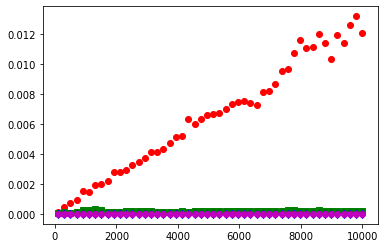

In [1]:
plt.plot(ns, ts_linsearch, 'or')
plt.plot(ns, ts_binsearch, 'sg')
plt.plot(ns, ts_setsearch, 'db')
plt.plot(ns, ts_dctsearch, 'om');

![img](c330ab22e12845d0448e5bd0545018bfe8504f19.png)



# Out[306]:

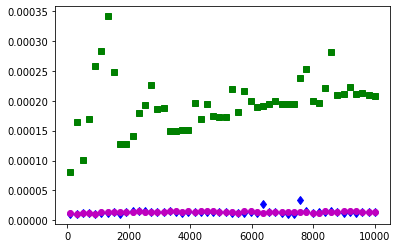

In [1]:
plt.plot(ns, ts_binsearch, 'sg')
plt.plot(ns, ts_setsearch, 'db')
plt.plot(ns, ts_dctsearch, 'om');

It looks like sets and dictionaries support lookup in constant time!
How?!



##### The `map` ADT



We will focus next on the "*map*" abstract data type (aka "associative
array" or "dictionary"), which is used to associate keys (which must be
unique) with values. Python's `dict` type is an implementation of the
map ADT.

Given an implementation of a map, it is trivial to implement a *set* on
top of it (how?).

-   `put(k,v)` - associated this key with this value in the map
-   `get(k)` - return the value associated with this key
-   `contains(k)` - returns `True` if the key exists in the map

Here's a simple map API:



In [1]:
class MapDS:
    def __init__(self):
        self.data = {}

    def __setitem__(self, key, value):
        self.data[key] = value

    def __getitem__(self, key):
        return self.data[key]

    def __contains__(self, key):
        return self.data.__contains__(key)

# Out[317]:

In [1]:
m = MapDS()
m['batman'] = 'bruce wayne'
m['superman'] = 'clark kent'
m['spiderman'] = 'peter parker'

# Out[308]:

In [1]:
m['batman']

# Out[309]:
'bruce wayne'

    'bruce wayne'



In [1]:
m['batman'] = 'tony stark'

# Out[310]:

In [1]:
m['batman']

# Out[311]:
'tony stark'

    'tony stark'

How do we make the leap from linear runtime complexity to constant?!



###### Sets



In [1]:
class SetDS:

    def __init__(self):
        self.data = MapDS()

    def add(self, v):
        self.data[v] = True

    def __contains__(self, v):
        return self.data.__contains__(v)

:results:
      # Out[318]:
      :end:

In [1]:
s = SetDS()
s.add("Batman")
s.add("Superman")
print("Batman" in s)
print("Superman" in s)
print("Ironman" in s)

:results:
      True
      True
      False
      :end:

##### Small keyspaces



-   keyspace `[0,n)`
-   for key `x` store the number of students that have a rounded (integer) GPA of `x`



In [1]:
def is_int(s):
    try:
        i = int(s)
    except ValueError:
        return False
    return True

class SmallIntMap:

    def __init__(self,n=5):
        self.n = n
        self.data = [None] * n

    def __setitem__(self,k,v):
        assert is_int(k) and k >= 0 and k < self.n
        self.data[k] = v

    def __getitem__(self,k):
        assert is_int(k) and k >= 0 and k < self.n
        assert self.data[k]
        return self.data[k]

    def __delitem__(self,k):
        assert is_int(k) and k >= 0 and k < self.n
        self.data[k] = None

    def __contains__(self,k):
        assert is_int(k) and k >= 0 and k < self.n
        return self[k]

    def __repr__(self):
        return '{ ' + ', '.join([ str(k) + ' -> ' + str(self.data[k]) for k in range(0,self.n) ]) +  '}'

    def __str__(self):
        return self.__repr__()

:results:
     # Out[326]:
     :end:

In [1]:
gpa_stats = SmallIntMap(5)
gpa_stats[0] = 0
gpa_stats[1] = 1
gpa_stats[2] = 15
gpa_stats[3] = 100
gpa_stats[4] = 3
gpa_stats[0] = 2
gpa_stats

# Out[328]:
{ 0 -> 2, 1 -> 1, 2 -> 15, 3 -> 100, 4 -> 3}

##### Direct lookups via *Hashing*



Hashes (a.k.a. hash codes or hash values) are simply numerical values
computed for objects.



In [1]:
hash('hello')

# Out[329]:
2856908769235993913

In [1]:
hash('batman')

# Out[330]:
-8257554836986143788

In [1]:
hash('batmen')

# Out[331]:
6410978048409935299

In [1]:
[hash(s) for s in ['different', 'objects', 'have', 'very', 'different', 'hashes']]

# Out[333]:
#+BEGIN_EXAMPLE
  [-8250942350797746702,
  833957209393847702,
  -6519000036645011232,
  3104284058903431793,
  -8250942350797746702,
  -568970268390236831]
#+END_EXAMPLE

In [1]:
[hash(s)%100 for s in ['different', 'objects', 'have', 'very', 'different', 'hashes']]

# Out[334]:
[98, 2, 68, 93, 98, 69]

##### Hashtables



In [1]:
class Hashtable:
    def __init__(self, n_buckets):
    self.buckets = [[]] * n_buckets

    def __setitem__(self, key, val):
    h = hash(key)
    bucket = self.buckets[h % len(self.buckets)]
    for k in bucket:
               if(k[0] == key):
                   k[1] = val
    bucket.append([key,val])

    def __getitem__(self, key):
    h = hash(key)
    for k in self.buckets[h % len(self.buckets)]:
    if(k[0] == key):
                   return k[1]
    raise Exception(f"key {key} not in hashtable")

    def __contains__(self, key):
    try:
    _ = self[key]

    return True
    except:
    return False

In [1]:
ht = Hashtable(100)
ht['spiderman'] = 'peter parker'
ht['batman'] = 'bruce wayne'
ht['superman'] = 'clark kent'

In [1]:
ht['spiderman']

    'peter parker'



In [1]:
ht['batman']

    'bruce wayne'



In [1]:
ht['superman']

    'clark kent'



In [1]:
ht['superman'] = 'bob'
ht['superman']

    'bob'



##### On Collisions



###### The "Birthday Problem"



Problem statement: Given $N$ people at a party, how likely is it that at
least two people will have the same birthday?



In [1]:
def birthday_p(n_people):
    p_inv = 1
    for n in range(365, 365-n_people, -1):
    p_inv *= n / 365
    return 1 - p_inv

In [1]:
birthday_p(3)

    0.008204165884781345



In [1]:
1-364/365*363/365

    0.008204165884781456



In [1]:
n_people = range(1, 80)
plt.plot(n_people, [birthday_p(n) for n in n_people]);

![img](d764b2052716d768ffe045cf53c2b0c13c9c5cb6.png)



###### General collision statistics



Repeat the birthday problem, but with a given number of values and
"buckets" that are allotted to hold them. How likely is it that two or
more values will map to the same bucket?



In [1]:
def collision_p(n_values, n_buckets):
    p_inv = 1
    for n in range(n_buckets, n_buckets-n_values, -1):
    p_inv *= n / n_buckets
    return 1 - p_inv

In [1]:
collision_p(23, 365) # same as birthday problem, for 23 people

    0.5072972343239857



In [1]:
collision_p(10, 100)

    0.37184349044470544



In [1]:
collision_p(100, 1000)

    0.9940410733677595



In [1]:
# keeping number of values fixed at 100, but vary number of buckets: visualize probability of collision
n_buckets = range(100, 100001, 1000)
plt.plot(n_buckets, [collision_p(100, nb) for nb in n_buckets]);

![img](8f125191a3fc94123848d21d57e9a7ae712b566a.png)



In [1]:
def avg_num_collisions(n, b):
    """Returns the expected number of collisions for n values uniformly distributed
    over a hashtable of b buckets. Based on (fairly) elementary probability theory.
    (Pay attention in MATH 474!)"""
    return n - b + b * (1 - 1/b)**n

In [1]:
avg_num_collisions(28, 365)

    1.011442040700615



In [1]:
avg_num_collisions(1000, 1000)

    367.6954247709637



In [1]:
avg_num_collisions(1000, 10000)

    48.32893558556316



##### Dealing with Collisions



To deal with collisions in a hashtable, we simply create a "chain" of
key/value pairs for each bucket where collisions occur. The chain needs
to be a data structure that supports quick insertion &#x2014; natural choice:
the linked list!



In [1]:
class Hashtable:
    class Node:
    def __init__(self, key, val, next=None):
    self.key = key
    self.val = val
    self.next = next

    def __init__(self, n_buckets=1000):
    self.buckets = [None] * n_buckets

    def __setitem__(self, key, val):
    bidx = hash(key) % len(self.buckets)

    def __getitem__(self, key):
    bidx = hash(key) % len(self.buckets)

    def __contains__(self, key):
    try:
    _ = self[key]
    return True
    except:
    return False

In [1]:
ht = Hashtable(1)
ht['batman'] = 'bruce wayne'
ht['superman'] = 'clark kent'
ht['spiderman'] = 'peter parker'

In [1]:
ht['batman']

In [1]:
ht['superman']

In [1]:
ht['spiderman']

In [1]:
def ht_search(ht, x):
    return x in ht

def init_ht(size):
    ht = Hashtable(size)
    for x in range(size):
    ht[x] = x
    return ht

ns = np.linspace(100, 10_000, 50, dtype=int)
ts_htsearch = [timeit.timeit('ht_search(ht, 0)',
                               #'ht_search(ht, {})'.format(random.randrange(n)),
                               setup='ht = init_ht({})'.format(n),
                               globals=globals(),
                               number=100)
                 for n in ns]

In [1]:
plt.plot(ns, ts_binsearch, 'ro')
plt.plot(ns, ts_htsearch, 'gs')
plt.plot(ns, ts_dctsearch, 'b^');

![img](6c2abfa5acc0a1b88f6131ede360364e10c9ce2a.png)



##### Loose ends



###### Iteration



In [1]:
class Hashtable(Hashtable):
    def __iter__(self):
    pass

In [1]:
ht = Hashtable(100)
ht['batman'] = 'bruce wayne'
ht['superman'] = 'clark kent'
ht['spiderman'] = 'peter parker'

In [1]:
for k in ht:
    print(k)

    
    TypeErrorTraceback (most recent call last)
    <ipython-input-83-43c83c094cda> in <module>
    ----> 1 for k in ht:
            2     print(k)
    
    TypeError: iter() returned non-iterator of type 'NoneType'



###### Key ordering



In [1]:
ht = Hashtable()
d = {}
for x in 'banana apple cat dog elephant'.split():
    d[x[0]] = x
    ht[x[0]] = x

In [1]:
for k in d:
    print(k, '=>', d[k])

    b => banana
    a => apple
    c => cat
    d => dog
    e => elephant



In [1]:
for k in ht:
    print(k, '=>', ht[k])

    
    TypeErrorTraceback (most recent call last)
    <ipython-input-86-74efa9b88228> in <module>
    ----> 1 for k in ht:
            2     print(k, '=>', ht[k])
    
    TypeError: iter() returned non-iterator of type 'NoneType'



###### Load factor & Rehashing



It is clear that the ratio of the number of keys to the number of
buckets (known as the **load factor**) can have a significant effect on
the performance of a hashtable.

A fixed number of buckets doesn't make sense, as it might be wasteful
for a small number of keys, and also scale poorly to a relatively large
number of keys. And it also doesn't make sense to have the user of the
hashtable manually specify the number of buckets (which is a low-level
implementation detail).

Instead: a practical hashtable implementation would start with a
relatively small number of buckets, and if/when the load factor
increases beyond some threshold (typically 1), it *dynamically increases
the number of buckets* (typically to twice the previous number). This
requires that all existing keys be *rehashed* to new buckets (why?).



###### Uniform hashing



Ultimately, the performance of a hashtable also heavily depends on
hashcodes being *uniformly distributed* &#x2014; i.e., where, statistically,
each bucket has roughly the same number of keys hashing to it. Designing
hash functions that do this is an algorithmic problem that's outside the
scope of this class!



##### Runtime analysis & Discussion



For a hashtable with $N$ key/value entries, we have the following
*worst-case runtime complexity*:

-   Insertion: $O(N)$
-   Lookup: $O(N)$
-   Deletion: $O(N)$

Assuming uniform hashing and rehashing behavior described above, it is
also possible to prove that hashtables have $O(1)$ *amortized runtime
complexity* for the above operations. Proving this is also beyond the
scope of this class (but is demonstrated by empirical data).



##### Vocabulary list



-   hashtable
-   hashing and hashes
-   collision
-   hash buckets & chains
-   birthday problem
-   load factor
-   rehashing

---



##### Addendum: On *Hashability*



Remember: *a given object must always hash to the same value*. This is
required so that we can always map the object to the same hash bucket.

Hashcodes for collections of objects are usually computed from the
hashcodes of its contents, e.g., the hash of a tuple is a function of
the hashes of the objects in said tuple:



In [1]:
hash(('two', 'strings'))

    4246727162495154915

This is useful. It allows us to use a tuple, for instance, as a key for
a hashtable.

However, if the collection of objects is *mutable* &#x2014; i.e., we can
alter its contents &#x2014; this means that we can potentially change its
hashcode.\`

If we were to use such a collection as a key in a hashtable, and alter
the collection after it's been assigned to a particular bucket, this
leads to a serious problem: the collection may now be in the wrong
bucket (as it was assigned to a bucket based on its original hashcode)!

For this reason, only immutable types are, by default, hashable in
Ipython. So while we can use integers, strings, and tuples as keys in
dictionaries, lists (which are mutable) cannot be used. Indeed, Ipython
marks built-in mutable types as "unhashable", e.g.,



In [1]:
hash([1, 2, 3])

    
    TypeErrorTraceback (most recent call last)
    <ipython-input-88-84d65be9aa35> in <module>
    ----> 1 hash([1, 2, 3])
    
    TypeError: unhashable type: 'list'

That said, Ipython does support hashing on instances of custom classes
(which are mutable). This is because the default hash function
implementation does not rely on the contents of instances of custom
classes. E.g.,



In [1]:
class Student:
    def __init__(self, fname, lname):
    self.fname = fname
    self.lname = lname

In [1]:
s = Student('John', 'Doe')
hash(s)

    298582137



In [1]:
s.fname = 'Jane'
hash(s) # same as before mutation

    298582137

We can change the default behavior by providing our own hash function in
`__hash__`, e.g.,



In [1]:
class Student:
    def __init__(self, fname, lname):
    self.fname = fname
    self.lname = lname

    def __hash__(self):
    return hash(self.fname) + hash(self.lname)

In [1]:
s = Student('John', 'Doe')
hash(s)

    7828797879385466672



In [1]:
s.fname = 'Jane'
hash(s)

    -7042091445038950747

But be careful: instances of this class are no longer suitable for use
as keys in hashtables (or dictionaries), if you intend to mutate them
after using them as keys!

